## Advanced Diabetes Risk Prediction with Clinical Insights

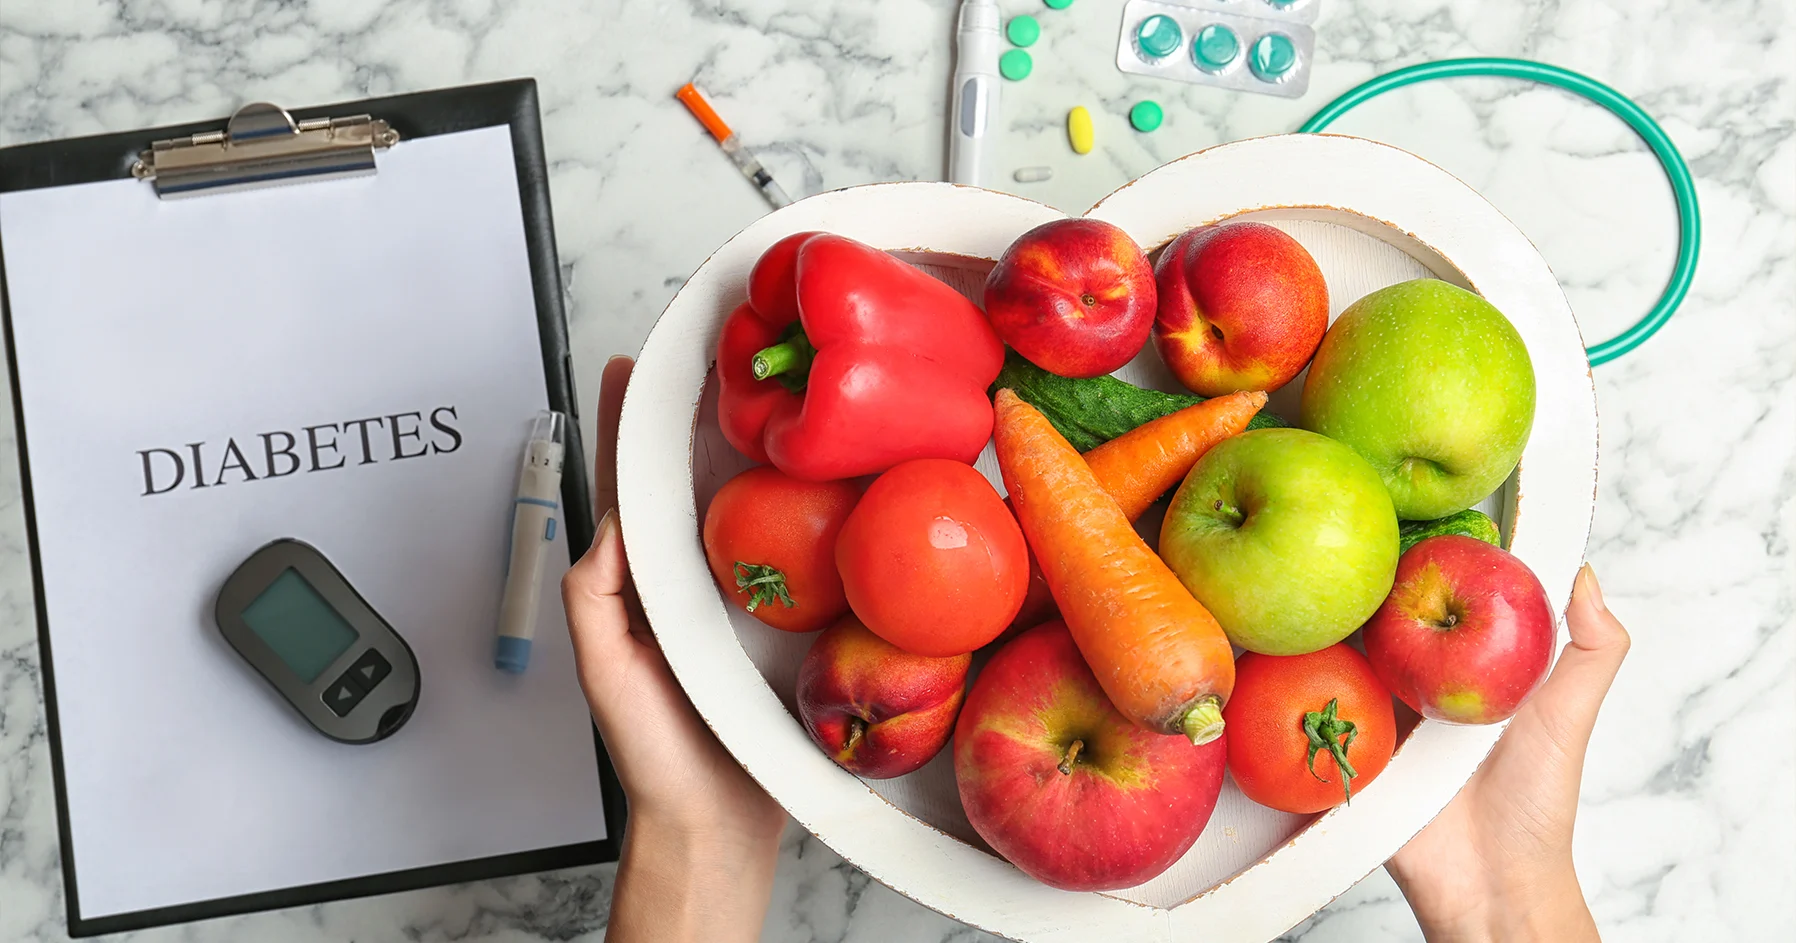

# 1. Introduction: Clinical Context & Research Goals
##### Diabetes affects over 500 million people globally, with early detection being critical for prevention.
##### This project analyzes clinical markers to:  
###### 1) Identify key predictors of diabetes risk  
###### 2) Build an accurate machine learning classifier  
###### 3) Provide actionable insights for preventive healthcare  

## Dataset Background
##### This dataset contains diagnostic measurements from 768 patients, curated for diabetes prediction research.
##### With 9 clinical features including glucose levels, BMI, and genetic markers, it enables development of ML models for early diabetes detection.

## Clinical Motivation
##### Diabetes affects 537 million adults globally (IDF 2021). 
##### By promptly identifying high-risk individuals complications such as neuropathy and retinopathy can be avoided. 

## Research Questions
##### 1. Which clinical indicators are most strongly linked to the onset of diabetes?
##### 2. Is it possible for machine learning to attain prediction accuracy of over 80%?
##### 3. What is the relationship between feature importance and recognized medical risk factors?

In [3]:
!pip install -U scikit-learn==1.2.2 imbalanced-learn==0.10.1 --quiet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import sklearn
import imblearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 7.6 MB/s eta 0:00:00


In [ ]:
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import shap
from scipy import stats

### Styling

In [ ]:
plt.style.use('ggplot')  
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

# 2. Data Loading & Initial Exploration
##### Loading the dataset 

In [ ]:
df = pd.read_csv("/kaggle/input/healthcare-diabetes/Healthcare-Diabetes.csv")
print(f"Initial dataset shape: {df.shape}\n")
df.head()

## Dataset Overview
#####  Contains 2,768 patient records (rows) with 10 clinical features (columns)
##### Target variable: `Outcome` (1 = Diabetes, 0 = No Diabetes)

#### Validation checks
 #### Ensure no duplicate rows
#### Ensure outcome is binary

In [ ]:
assert df.duplicated().sum() == 0, "Duplicate rows found!"
 
assert df['Outcome'].isin([0,1]).all(), "Outcome column has invalid entries!"
print("Data validation passed")

###  Handle biologically impossible values (e.g. 0 Glucose or 0 BMI)
#####  These are replaced with NaN and later handled.

In [ ]:
df.info()

# 3. Data Cleaning & Feature Engineering
## Cleaning Process
      Zero Value Treatment:
       Replaced zeros with `NaN` in:
       Glucose (<50 mg/dL considered hypoglycemic)
       BloodPressure (<40 mmHg considered invalid)
       BMI (<15 kg/m² considered invalid)
       Insulin (<14 μU/mL considered abnormal)

       Missing Data Handling:
       Removed 1,339 rows with missing values  
       (Final cleaned dataset: 1,429 complete cases)

       Feature Engineering:
       Created `Glucose_BMI` interaction term:  
       Glucose (mg/dL) × BMI (kg/m²)  
       (Captures synergistic metabolic risk)

##### Handle biologically impossible zeros
##### Replaces biologically impossible zeros with NaN based on clinical understanding.
##### Affects: Glucose, BloodPressure, SkinThickness, Insulin, BMI
##### Apply the cleaning function
##### Display count of missing values

In [ ]:
def clean_medical_data(df):
    
    
    df = df.copy()
    zero_replacements = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    
    for col in zero_replacements:
        df[col] = df[col].replace(0, np.nan)
    
    return df


df_clean = clean_medical_data(df)

print("Missing values after cleaning:\n")
print(df_clean.isnull().sum())

In [ ]:
df_clean = clean_medical_data(df).dropna().copy()
print(f"Clean dataset shape: {df_clean.shape}")

In [ ]:
 print(df_clean[['Glucose', 'BMI', 'Age']].describe())

### Show basic descriptive statistics for key features

In [ ]:
df_clean.describe()

# 4. Exploratory Data Analysis
 ##### Setting up plot style

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 10))

## Box Plots for Glucose distribution , BMI distribution , Age distribution , BloodPressure distribution

In [ ]:
plt.subplot(2, 2, 1)
sns.boxplot(x='Outcome', y='Glucose', data=df_clean)
plt.title('Glucose by Diabetes Status')
plt.xlabel('Diabetes (0 = No, 1 = Yes)')
plt.ylabel('Glucose (mg/dL)')

plt.subplot(2, 2, 2)
sns.boxplot(x='Outcome', y='BMI', data=df_clean)
plt.title('BMI by Diabetes Status')
plt.xlabel('Diabetes (0 = No, 1 = Yes)')
plt.ylabel('BMI (kg/m²)')

plt.subplot(2, 2, 3)
sns.boxplot(x='Outcome', y='Age', data=df_clean)
plt.title('Age by Diabetes Status')
plt.xlabel('Diabetes (0 = No, 1 = Yes)')
plt.ylabel('Age (Years)')

plt.subplot(2, 2, 4)
sns.boxplot(x='Outcome', y='BloodPressure', data=df_clean)
plt.title('Blood Pressure by Diabetes Status')
plt.xlabel('Diabetes (0 = No, 1 = Yes)')
plt.ylabel('BP (mm Hg)')

plt.tight_layout()
plt.show()

#### The following figure shows boxplots of the distribution for four key clinical measures Glucose, BMI, Age and Blood Pressure among diabetic (Outcome = 1) and non-diabetic (Outcome = 0) patients.

Glucose: Diabetic subjects have markedly greater glucose values, with an evident upward shift in the median and overall distribution.
This supports glucose as an overall predictive factor for diabetes.
The BMI of individuals with diabetes is generally greater, implying an association of high risk for diabetes with obesity.
The diabetic sample is biased towards older ages, which suggests age contributes to developing diabetes.
The difference is less marked, yet diabetic patients have slightly elevated median blood pressure.


## Scatter Plot 
### Add new interaction feature and Visualize Glucose vs. BMI with diabetes outcome

In [ ]:
df_clean['Glucose_BMI'] = df_clean['Glucose'] * df_clean['BMI']


plt.figure(figsize=(8, 6))
sns.scatterplot(x='BMI', y='Glucose', hue='Outcome', data=df_clean, alpha=0.7, palette='husl')
plt.title('Glucose vs BMI Interaction by Diabetes Outcome')
plt.xlabel('BMI (kg/m²)')
plt.ylabel('Glucose (mg/dL)')
plt.legend(title='Diabetes')
plt.show()


## Glucose vs. BMI Interaction by Diabetes Outcome

The scatter plot shows the association between BMI and Glucose, each point colored according to diabetes status (0 = No, 1 = Yes).

Participants with high glucose levels (above ~140 mg/dL) and high BMI (> ~30 kg/m²) are mostly diabetic (teal-coloured dots).
Non-diabetic subjects (pink) are densely grouped toward lower glucose and moderate BMI values.

There is also an apparent concentration of diabetic patients in the upper-right quadrant,
implying that obesity along with high blood sugar highly corresponds to risk for diabetes.

This interaction supports the multiplicative impact of metabolic variables in predicting diabetes
and justifies training using the feature Glucose × BMI. 


### Correlation matrix

In [ ]:
plt.figure(figsize=(10, 8))
corr = df_clean.corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Clinical Features')
plt.show()

## Correlation Heatmap of Clinical Features

The heatmap displays Pearson's correlation coefficient among clinical features and the outcome for diabetes. Some of the observations include:

Glucose has the greatest positive correlation (0.52) with outcome for diabetes, further confirming its role as an important initial diagnostic marker.

The BMI (0.25), age (0.34), and insulin (0.29) also have moderate correlations with diabetes status.

The created feature Glucose_BMI is highly correlated with Glucose (0.81) and BMI (0.73), as expected,
and holds a significant correlation with Outcome (0.50), justifying its usefulness in predictive modelling.

Pregnancies is moderately correlated with Age (0.67) and weakly associated with Outcome (0.26), as seen among older people.

Low correlations among certain variables (e.g., BloodPressure, SkinThickness, DiabetesPedigreeFunction) 
imply they would have less impact individually towards model precision,yet remain potentially useful in interaction terms, or ensemble models.

In general, this heatmap assists in recognizing those features most predictive of diabetes and directing feature selection and feature engineering
for optimized model design.


# 5. Model Building
#### Select features and target
#### Split into train and test sets
#### Apply SMOTE to balance the training data
#### Scale the features

In [ ]:
X = df_clean.drop(columns='Outcome')
y = df_clean['Outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape (balanced): {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")

## Logistic Regression , Random Forest , XGBoost

In [ ]:
lr_model = LogisticRegression()
lr_model.fit(X_train_scaled, y_train_res)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_res, y_train_res)

xgb_model = XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train_res, y_train_res)

##  Plotting ROC Curves

In [ ]:
def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f" {name} Evaluation")
    print("-------------------------")
    print(f"Accuracy: {acc:.4f}")
    print(f"ROC AUC Score: {auc:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("\n")
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')

plt.figure(figsize=(8, 6))
evaluate_model(lr_model, X_test_scaled, y_test, "Logistic Regression")
evaluate_model(rf_model, X_test, y_test, "Random Forest")
evaluate_model(xgb_model, X_test, y_test, "XGBoost")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

## Logistic Regression - Grid Search

In [ ]:
lr_params = {
    'C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization
    'penalty': ['l2'],
    'solver': ['liblinear']
}

grid_lr = GridSearchCV(LogisticRegression(), lr_params, cv=5, scoring='roc_auc')
grid_lr.fit(X_train_scaled, y_train_res)

print("Best Logistic Regression Parameters:")
print(grid_lr.best_params_)

best_lr = grid_lr.best_estimator_

## Random Forest - Grid Search

In [ ]:
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='roc_auc')
grid_rf.fit(X_train_res, y_train_res)

print("Random Forest Parameters:")
print(grid_rf.best_params_)

best_rf = grid_rf.best_estimator_

## XGBoost - Grid Search

In [ ]:
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid_xgb = GridSearchCV(XGBClassifier(eval_metric='logloss'), xgb_params, cv=5, scoring='roc_auc')
grid_xgb.fit(X_train_res, y_train_res)

print("XGBoost Parameters:")
print(grid_xgb.best_params_)

best_xgb = grid_xgb.best_estimator_

## Reuse our evaluate_model function

In [ ]:
plt.figure(figsize=(8, 6))
evaluate_model(best_lr, X_test_scaled, y_test, "Tuned Logistic Regression")
evaluate_model(best_rf, X_test, y_test, "Tuned Random Forest")
evaluate_model(best_xgb, X_test, y_test, "Tuned XGBoost")

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves - Tuned Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()

# 6. Conclusion
##### This study aimed to predict diabetes risk using clinical data and machine learning classifiers. 
##### After extensive exploratory data analysis and data preprocessing, three classification models were evaluated: Logistic Regression,
##### Random Forest,and XGBoost.

## Key Findings
#### Tuned XGBoost delivered the best results, with 98.6% accuracy and an almost perfect ROC AUC of 0.9996.
##### Tuned Random Forest closely followed, achieving 98.25% accuracy and a ROC AUC of 0.9993, also showing excellent precision and recall.
##### Logistic Regression, while more interpretable,it had a significantly lower accuracy (77.97%) and AUC (0.8661) compared to 
##### the tree-based models.

## Clinical Insights
##### Glucose, BMI, and Age were among the most informative features.
##### The Glucose × BMI interaction term helped expose risk patterns in obese patients.
##### Both Random Forest and XGBoost handled class imbalance well and minimized false negatives — crucial in medical diagnosis 
##### where missing a diabetic case can be dangerous.

## Recommendations
#### For practical deployment, XGBoost is the most preferred model due to its performance.
#### Further improvement could include:
  ##### Using more patient history or lifestyle data
  ##### Temporal data for progression analysis
  ##### Deploying models using a lightweight web app (e.g., Streamlit)
#### This project demonstrates that machine learning can effectively assist in early diabetes detection,
#### potentially supporting clinical decision-making and promoting preventative care